# Generate EEG with Gaussian Processes
January 2022
Noam Siegel

In [59]:
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import torch
from matplotlib.colors import LogNorm
from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing, svm, mixture
from sklearn.model_selection import train_test_split

from msc.results_collectors import GPResultsCollector

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
requested_params = ['covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale']
results_df = GPResultsCollector(requested_params).results_df

getting page=1/5
getting page=2/5
getting page=3/5
getting page=4/5
getting page=5/5


In [61]:
results_df[requested_params + ['label_desc']]

,covar_module.raw_outputscale,covar_module.base_kernel.raw_lengthscale,label_desc
0,5.593661,-4.332324,ictal
1,5.499009,-4.160838,ictal
2,5.654957,-4.231129,ictal
3,4.979059,-4.197177,ictal
4,5.826498,-4.445915,ictal
...,...,...,...
2495,-2.190757,-4.857003,interictal
2496,-2.814209,-4.658861,interictal
2497,-2.495524,-4.941966,ictal
2498,-2.666079,-4.941070,ictal


Text(0.5, 0.98, 'Matern Kernel Params for Dog_1 Dataset')

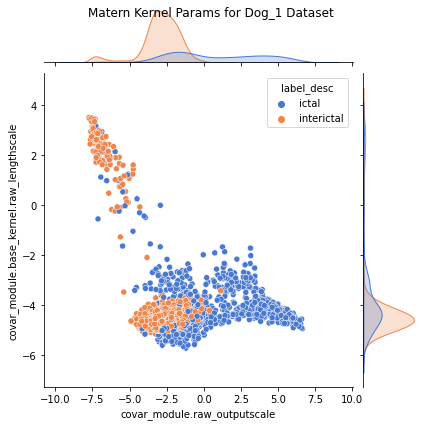

In [62]:
sns.jointplot(data=results_df, x=requested_params[0], y=requested_params[1], hue="label_desc", palette="muted",
              legend=True)
plt.suptitle("Matern Kernel Params for Dog_1 Dataset")

## Check AUC ROC

C:\Users\noam\AppData\Local\Temp\ipykernel_24528\4251810162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["label"] = le.transform(results_df.label_desc)


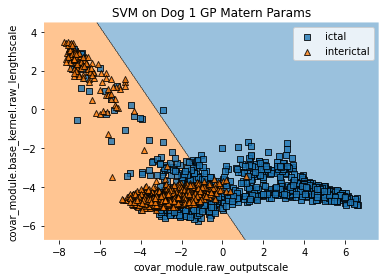

In [64]:
# encode labels
le = preprocessing.LabelEncoder()
le.fit(results_df.label_desc)
results_df["label"] = le.transform(results_df.label_desc)

# get all data
X = results_df[requested_params].to_numpy()
y = results_df["label"].to_numpy()

# split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train a classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# plot decision regions
plot_decision_regions(X, y, clf=clf, legend=2)

# add axes annotations
plt.xlabel(requested_params[0])
plt.ylabel(requested_params[1])
plt.title('SVM on Dog 1 GP Matern Params')

# add legend
L = plt.legend()
L.get_texts()[0].set_text(le.classes_[0])
L.get_texts()[1].set_text(le.classes_[1])
plt.show()


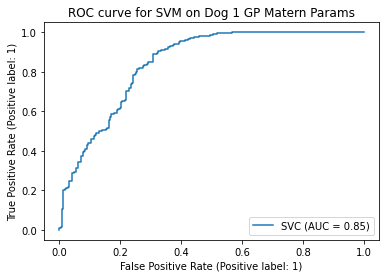

In [65]:
# plot ROC curve
sklearn.metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC curve for SVM on Dog 1 GP Matern Params")
plt.show()

## Density estimation with Gaussian mixture models

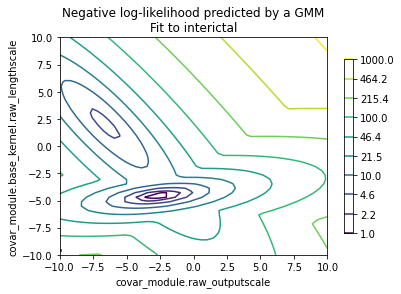

In [68]:
# selected label_desc parameters
X = torch.Tensor(
    results_df.loc[results_df["label_desc"] == 'interictal', requested_params].to_numpy())

# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(X)

# display predicted scores by the model as a contour plot
x = np.linspace(-10.0, 10.0)
y = np.linspace(-10.0, 10.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X[:, 0], X[:, 1], 0.8)

# add axes annotations
plt.xlabel(requested_params[0])
plt.ylabel(requested_params[1])

# add title
plt.title("Negative log-likelihood predicted by a GMM\nFit to interictal")
plt.axis("tight")
plt.show()

## Sample from density estimator

In [69]:
# sample GP model params
params, _ = gmm.sample()

## Define Matern kernel Gaussian process

In [70]:
class EEGGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        gpytorch.models.ExactGP.__init__(self, train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(1.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        cover_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cover_x)

## Initialize Gaussian process from sampled params

In [71]:
# build GP model from sampled params
likelihood = gpytorch.likelihoods.GaussianLikelihood()
times = torch.linspace(0, 1, 401)
model = EEGGPModel([], [], likelihood)
model.covar_module.raw_outputscale.data.fill_(params[0, 0])
model.covar_module.base_kernel.raw_lengthscale.data.fill_(params[0, 1]);

## Sample EEG from Gaussian process

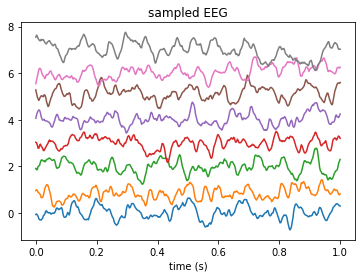

In [72]:
# sample EEG from GP model
n_channels = 8
sample = model(times).sample(torch.Size([n_channels]))

# plot EEG sample
plt.clf()
fig = plt.gcf()
ax = fig.add_subplot()
ax.set_xlabel("time (s)")
for i in range(len(sample)):
    channel = sample[i]
    channel += i
    ax.plot(times, channel)
plt.title("sampled EEG")
plt.show()